# AIoT 期末報告
## 說明
- dataset\solar_data_202003_202007.csv 為 **新竹市北區海濱路240號** 新竹市環保局掩埋場復育地太陽能案場在 **3月至7月** 其中一個inverter(逆變器)的太陽能發電資料

將資料集(dataset)內的 solar_data_202003_202007.csv 的太陽能案場發電資料做為訓練資料集訓練你的預測模型，用機器學習及深度學習皆可，預測 2020年一月、二月、八月、九月、十月的 **"下一個小時"的發電度數** 。

# 作業
[作業網址: http://aiot.codingmaster.cc:8000](http://aiot.codingmaster.cc:8000)
### 登入帳號為
- 大同大學： ttu + 學號

In [ ]:
# 抽卡!!!
!/opt/bin/nvidia-smi

Wed Jun  2 05:56:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# 下載資料集
!gdown --id '1WbbqzP3veoI155D6rPco4sbVVAN8kEJp' --output training_data.csv
!gdown --id '1kjRjzk9mt2JJAiEraUNGo14526ftO537' --output test_data.csv

!gdown --id '197ftcYXtGVuR0-dwo2ViwrkdWxIg93bU' --output weather_train.csv
!gdown --id '1c2hgvrbhQyAvdbDaGkWoc1y3JsLNweVk' --output weather_test.csv
!gdown --id '11O9R1tJTRmiGuRlc7MODRen3gZ7M8lYH' --output new_test_data.csv

Downloading...
From: https://drive.google.com/uc?id=1WbbqzP3veoI155D6rPco4sbVVAN8kEJp
To: /content/training_data.csv
3.65MB [00:00, 32.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kjRjzk9mt2JJAiEraUNGo14526ftO537
To: /content/test_data.csv
100% 44.9k/44.9k [00:00<00:00, 36.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=197ftcYXtGVuR0-dwo2ViwrkdWxIg93bU
To: /content/weather_train.csv
100% 278k/278k [00:00<00:00, 4.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=1c2hgvrbhQyAvdbDaGkWoc1y3JsLNweVk
To: /content/weather_test.csv
100% 362k/362k [00:00<00:00, 3.17MB/s]
Downloading...
From: https://drive.google.com/uc?id=11O9R1tJTRmiGuRlc7MODRen3gZ7M8lYH
To: /content/new_test_data.csv
100% 54.6k/54.6k [00:00<00:00, 7.55MB/s]


In [ ]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

  
def sameSeed(myseed = 0): # set a random seed for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(myseed)
    torch.manual_seed(myseed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(myseed)

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    print(loss_record['train'])
    print(loss_record['validate'])
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['validate'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['validate'], c='tab:cyan', label='validate')
    plt.ylim(0.0, 400.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [ ]:
def filter_outlier(df, column_name):
  q1 = df[column_name].quantile(0.25)
  q3 = df[column_name].quantile(0.75)
  iqr = q3 - q1
  fence_low = q1 - 1.5 * iqr
  fence_high = q3 + 1.5 * iqr
  df = df.loc[(df2[column_name] > fence_low) & (df[column_name] < fence_high)]
  return df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


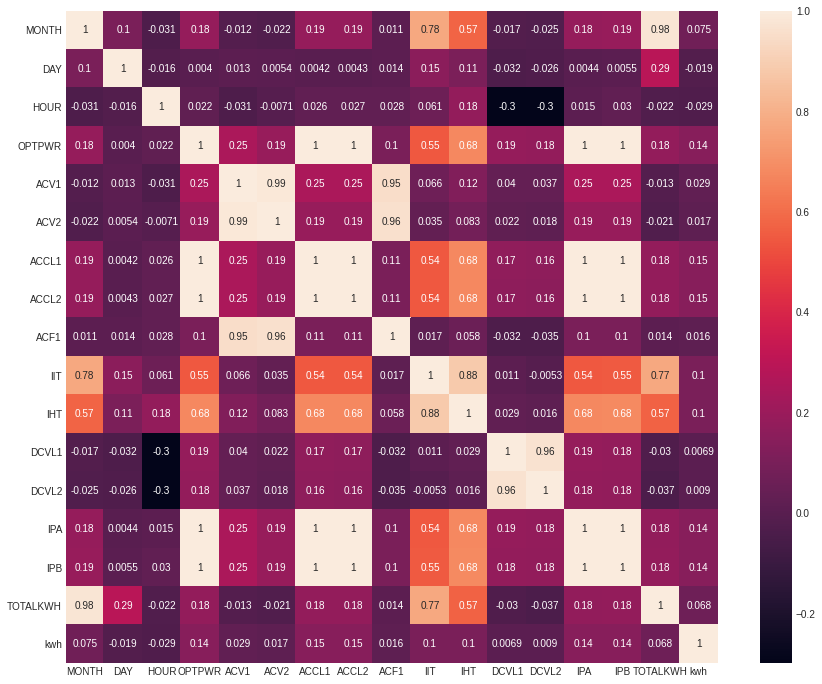

,MONTH,DAY,HOUR,OPTPWR,ACV1,ACV2,ACCL1,ACCL2,ACF1,IIT,IHT,DCVL1,DCVL2,IPA,IPB,TOTALKWH,kwh
0,3,1,6,1.54,231.0,228.0,3.0,2.7,60.1,31.0,25.0,778.0,771.0,0.78,0.78,43355.0,3.100
1,3,1,7,4.85,231.0,228.0,7.5,6.8,60.2,37.0,38.0,770.0,780.0,2.42,2.42,43358.0,7.349
2,3,1,8,9.62,233.0,228.0,14.3,13.6,60.1,39.0,42.0,772.0,771.0,4.89,4.89,43365.0,7.851
3,3,1,9,15.28,232.0,228.0,22.3,21.6,60.1,41.0,36.0,780.0,770.0,6.77,8.10,43373.0,3.695
4,3,1,10,7.55,231.0,227.0,11.4,10.6,60.1,41.0,46.0,778.0,760.0,3.76,3.77,43376.0,7.912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655,7,31,13,21.90,229.0,225.0,33.0,32.1,60.4,57.0,62.0,695.0,672.0,11.18,11.13,62055.0,19.139
3656,7,31,14,20.80,230.0,228.0,30.4,29.7,60.3,55.0,59.0,710.0,694.0,10.57,10.48,62074.0,14.100
3657,7,31,15,18.20,231.0,228.0,27.0,25.9,60.1,52.0,53.0,724.0,719.0,9.19,9.16,62088.0,8.439
3658,7,31,16,13.75,230.0,228.0,20.3,19.7,60.1,51.0,48.0,705.0,720.0,6.79,7.01,62097.0,4.947


In [ ]:
df = pd.read_csv('/content/training_data.csv')
df.insert(4, 'timedelta', 0)
df.insert(5, 'kwh', 0)
df['Local_Time'] = df['Local_Time'].str.replace('.000', '')

df['Local_Time'] = pd.to_datetime(df['Local_Time'], format='%Y-%m-%d %H:%M:%S')
df['timedelta'] = (df['Local_Time'].values.astype('int64')  // 10**9) \
                    - (df['Local_Time'].shift(1).values.astype('int64') // 10**9)
df['timedelta'][0] = 0

df['kwh'] = df['OPTPWR'].rolling(2).sum() / 2
df['kwh'] = (df['kwh'] * df['timedelta'] / 3600).round(3)

df2 = pd.DataFrame()
df2 = df[['Local_Time','OPTPWR','timedelta','kwh','ACV1','ACV2','ACCL1','ACCL2','ACF1','IIT','IHT','DCVL1','DCVL2','IPA','IPB','TOTALKWH']]

df2 = df2.groupby(pd.Grouper(key='Local_Time', freq='60Min')).max().reset_index()

df3 = df.groupby(pd.Grouper(key='Local_Time', freq='60Min')).sum().reset_index()
df2['kwh'] = df3['kwh']

df2 = df2.drop(df2[df2['kwh'] <= 0].index)
df2 = df2.drop(columns='timedelta')

df2.insert(1, 'HOUR', 0)
df2.insert(1, 'DAY', 0)
df2.insert(1, 'MONTH', 0)
df2['MONTH'] = pd.DatetimeIndex(df2['Local_Time']).month
df2['DAY'] = pd.DatetimeIndex(df2['Local_Time']).day
df2['HOUR'] = pd.DatetimeIndex(df2['Local_Time']).hour

df2 = df2.drop(columns='Local_Time')
df2.insert(len(df2.columns)-1, 'kwh', df2.pop('kwh'))
import seaborn as sns
corr2 = df2.corr()
plt.figure(figsize=(15,12)) # 調整圖片大小
sns.heatmap(corr2,cbar=True, annot=True, square=True) # 繪製熱度圖並將顏色設定為PuOr
plt.show()
# TODO[Medium]: 資料過濾，檢查資料是否正常
df2 = filter_outlier(df2, "kwh")
df2 = filter_outlier(df2, "ACV1")
df2 = filter_outlier(df2, "ACV2")
df2 = filter_outlier(df2, "DCVL1")
df2 = filter_outlier(df2, "DCVL2")
# TODO[Medium]: 我們要預測的是 "下一個" 小時的發電量
df2['kwh'] = df2['kwh'].shift(-1)
df2 = df2[:-1]

df2.to_csv('/content/training_data_processed.csv', header=False)

df2

In [ ]:
# TODO[Boss]: 加入氣象資料 (https://e-service.cwb.gov.tw/HistoryDataQuery/)

training_data = []
with open('/content/training_data_processed.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        training_data.append(row)

weather_train_data = []
with open('/content/weather_train.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        weather_train_data.append(row)

for item in weather_train_data:
    item.pop(2)
    item.pop(2)
    for i in range(9):
        item.pop(3)
    item.pop(4)
    item.pop(5)

for i in range(len(training_data)):
  date = "2020/%d/%d" % (int(training_data[i][1]), int(training_data[i][2]))
  hour = "%d" % (int(training_data[i][3]))
  for j in range(1, len(weather_train_data)):
    if weather_train_data[j][0] == date and weather_train_data[j][1] == hour:
      training_data[i].insert(-1, weather_train_data[j][2])
      training_data[i].insert(-1, weather_train_data[j][3])
      training_data[i].insert(-1, weather_train_data[j][4])
      break

training_data[:18] = training_data[:18].shift(-1)
training_data = training_data[:-1]

with open("new_training_data_processed.csv", "a", newline="", encoding="utf-8") as fp:
  writer = csv.writer(fp)
  for test in training_data:
    writer.writerow(test)

AttributeError: ignored

In [ ]:
from itertools import chain

class SolarDataset(Dataset):
    def __init__(self, path, mode='train', shuffle=False):
        self.mode = mode
        
        with open(path, 'r') as fp:
            lines = fp.readlines()
            if mode == 'test':
                lines.pop(0)
        if shuffle:
            import random
            random.seed(0)
            random.shuffle(lines)
        for line in lines:
            temp = line.split(',')
            break

        len_features = 7 # 資料特徵數量
        data = np.empty((0, len_features), float)
        target = np.empty((0, 1), float)
        target = np.array([])
        for line in lines:
            temp_s = line.replace('\n', '').split(',')
            temp = [t if t != '' else 0 for t in temp_s ]
            # data = np.append(data, np.array([temp[:len_features]]).astype(np.float), axis=0)
            # TODO[Medium]: 選取重要的特徵資料 
            #  1	 2   3    4   5   6   7   8   9    10   11  12   13    14  15    16     17     18    19  20
            # MONTH	DAY	HOUR  OPTPWR	ACV1	ACV2	ACCL1	ACCL2	ACF1	IIT	  IHT	DCVL1	  DCVL2	IPA	  IPB	TOTALKWH  Temperature	 GloblRad	UVI	kwh   
            # 3	  1	  6	  1.54	231.0	  228.0	3.0	  2.7	60.1  31.0	25.0 778.0	771.0	0.78	0.78	43355.0	                3.100
            # 3	  1	  7	  4.85	231.0	  228.0	7.5   6.8	60.2	37.0	38.0 770.0	780.0	2.42	2.42	43358.0	                7.349
            # 3	  1	  8	  9.62	233.0	  228.0	14.3  13.6 60.1	 39.0	 42.0	772.0	 771.0 4.89	 4.89	 43365.0                 7.851
            data = np.append(data, np.array([list(chain(temp[3:5], temp[7:9], temp[10:12], temp[18:19]))]).astype(np.float), axis=0)
            target = np.append(target, np.array([temp[-1]]).astype(np.float), axis=0)
        
        if mode == 'train':
            indices = [i for i in range(len(data)) if i % 10 != 0]
        elif mode == 'validate':
            indices = [i for i in range(len(data)) if i % 10 == 0]
        else:
            indices = [i for i in range(len(data))]

        self.data = torch.FloatTensor(data[indices])
        self.target = torch.FloatTensor(target[indices])
        self.dim = self.data.shape[1]

        self.data[:, 0:] = \
            (self.data[:, 0:] - self.data[:, 0:].mean(dim=0, keepdim=True)) \
            / self.data[:, 0:].std(dim=0, keepdim=True)

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'validate']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]
    
    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [ ]:
SolarDataset('/content/new_training_data_processed.csv')

In [ ]:
def prep_dataloader(path, mode, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = SolarDataset(path, mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [ ]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO[Strong, Boss]: 要如何修改模型增加預測的準確度?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.Sigmoid(),
            nn.Linear(4, 1),
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

In [ ]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''
    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'validate': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['validate'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [ ]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [ ]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/                  # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
# config = {
#     'n_epochs': 5000,                # maximum number of epochs
#     'batch_size': 128,               # mini-batch size for dataloader
#     # TODO[Strong]: 嘗試其他 optimizer ，參考 https://pytorch.org/docs/stable/optim.html
#     'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
#     'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
#         'lr': 0.0001,                 # learning rate of SGD
#         'momentum': 0.9              # momentum for SGD
        
#     },
#     'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
#     'save_path': 'models/model.pth'  # your model will be saved here
# }

config = {
    'n_epochs': 5000,                # maximum number of epochs
    'batch_size': 128,               # mini-batch size for dataloader
    # TODO[Strong]: 嘗試其他 optimizer ，參考 https://pytorch.org/docs/stable/optim.html
    'optimizer': 'RMSprop',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,
                      # momentum for SGD
        
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [ ]:
tr_set = prep_dataloader('/content/new_training_data_processed.csv', 'train', config['batch_size'])
dv_set = prep_dataloader('/content/new_training_data_processed.csv', 'validate', config['batch_size'])

In [ ]:
sameSeed(0)
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 134.0444)
Saving model (epoch =    2, loss = 130.9469)
Saving model (epoch =    3, loss = 128.6697)
Saving model (epoch =    4, loss = 126.7298)
Saving model (epoch =    5, loss = 124.9406)
Saving model (epoch =    6, loss = 123.1386)
Saving model (epoch =    7, loss = 121.1389)
Saving model (epoch =    8, loss = 118.9015)
Saving model (epoch =    9, loss = 116.4105)
Saving model (epoch =   10, loss = 113.5477)
Saving model (epoch =   11, loss = 110.4090)
Saving model (epoch =   12, loss = 107.1918)
Saving model (epoch =   13, loss = 103.9532)
Saving model (epoch =   14, loss = 100.7160)
Saving model (epoch =   15, loss = 97.3902)
Saving model (epoch =   16, loss = 94.1880)
Saving model (epoch =   17, loss = 91.1454)
Saving model (epoch =   18, loss = 88.2614)
Saving model (epoch =   19, loss = 85.4471)
Saving model (epoch =   20, loss = 82.7282)
Saving model (epoch =   21, loss = 80.0646)
Saving model (epoch =   22, loss = 77.5140)
Saving model (epoc

[117.32769775390625, 147.6892852783203, 131.91781616210938, 128.3089599609375, 134.4908905029297, 145.53802490234375, 143.1405792236328, 142.80316162109375, 152.44235229492188, 145.66445922851562, 140.6708984375, 162.72341918945312, 151.2708740234375, 125.41026306152344, 158.72901916503906, 155.50277709960938, 144.29371643066406, 133.88258361816406, 151.34573364257812, 144.65289306640625, 135.78225708007812, 137.42190551757812, 136.10348510742188, 132.30136108398438, 142.80284118652344, 134.78173828125, 171.4508056640625, 106.45660400390625, 106.17460632324219, 158.87579345703125, 129.58004760742188, 110.98123931884766, 122.91023254394531, 129.21791076660156, 109.14707946777344, 157.22894287109375, 134.0450897216797, 134.51800537109375, 138.85562133789062, 117.38720703125, 131.01953125, 131.44374084472656, 112.3015365600586, 120.08918762207031, 134.69432067871094, 130.91342163085938, 127.47257232666016, 134.56130981445312, 135.15667724609375, 123.35678100585938, 154.05311584472656, 134

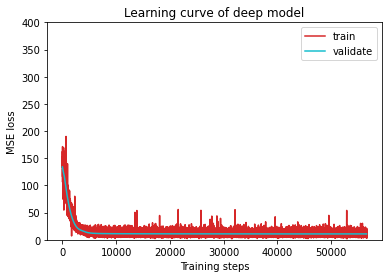

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

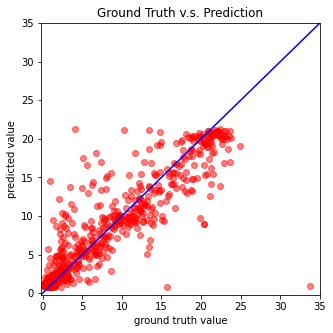

In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def test(tt_set, model, device, mode='validate'):
    model.eval()                                # set model to evalutation mode
    preds = []
    if mode != 'test':
        targets = np.array([])
        for x, y in tt_set:                            # iterate through the dataloader
            targets = np.concatenate((targets, y.cpu().numpy()))
            x = x.to(device)                        # move data to device (cpu/cuda)
            with torch.no_grad():                   # disable gradient calculation
                pred = model(x)                     # forward pass (compute output)
                preds.append(pred.detach().cpu())   # collect prediction
        preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
        mse = mean_squared_error(targets, preds)
        r2 = r2_score(targets, preds)
        print('validate mse: %.3f, r2: %.3f' % (mse, r2))
    else:
        for x in tt_set:                            # iterate through the dataloader
            x = x.to(device)                        # move data to device (cpu/cuda)
            with torch.no_grad():                   # disable gradient calculation
                pred = model(x)                     # forward pass (compute output)
                preds.append(pred.detach().cpu())   # collect prediction
        preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'predict_kwh'])
        for i, p in enumerate(preds):
            writer.writerow([i+1, p])

preds = test(dv_set, model, device)  
save_pred(preds, 'pred.csv')   

validate mse: 10.777, r2: 0.799
Saving results to pred.csv


In [ ]:
test_set = prep_dataloader('/content/new_test_data.csv', 'test', config['batch_size'])

In [ ]:
preds = test(test_set, model, device, mode='test')  # 產生預測資料
save_pred(preds, 'pred.csv') 

Saving results to pred.csv


# 作業繳交
- 將作業 .csv檔案 上傳即可看到分數

## 期末分數
### 實作(70%)
- 取最低的 MSE
- Simple Baseline: 60~69分
- Medium Baseline: 70~79分
- Strong Baseline: 80~89分
- Boss Baseline: 90~100分

### 報告(30%)
- 每組 1-3 人
- 每組報告 5 - 10 分鐘
- 報告 Outlines
    - 組員及分工
    - 資料處理方式
    - 使用的訓練模型 (成功做出兩個或以上模型會加分，有機器學習與深度學習的比較更佳)
    - 最高分數 與 分析模型優點 (or 多個模型間的互相比較)
    - 過程中遇到的困難及如何解決 or 心得 or 這學期上課的收穫
    - 課程建議 (如果沒有建議可以不用)

### 報告順序
將在 5/19(三) 上課時抽出

# 注意事項及規則
- 每組一天只能上傳五次，請勿用任何方式上傳超過五次
- 伺服器又貴又脆弱，請不要攻擊它QQ
- 請不要把你的預測資料給其他同學上傳
- 請不要分享你的 CODE 給其他同學或是其他生物
- 請勿使用你用其他管道拿到其它天的發電資料，或是在網路上找到的其他發電資料
- 請勿使用任何別人已經訓練過的 pre-train model
- 伺服器會記錄你每次上傳的答案，所以很容易抓到你上傳其他同學的資料
- 違反以上任何規則，以作弊論，期末作業直接0分，不得異議